In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import auc,roc_curve,roc_auc_score

import tensorflow as tf
print("Tensorflow version:", tf.__version__)


import tensorflow.keras as keras

Tensorflow version: 2.9.1


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image

#!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [17]:
for dirname, _, filenames in os.walk('D:/MUM/Machine Learning/Project4/dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename));

D:/MUM/Machine Learning/Project4/dataset/fer2013.csv
D:/MUM/Machine Learning/Project4/dataset/fer2013.tar.gz
D:/MUM/Machine Learning/Project4/dataset/icml_face_data.csv
D:/MUM/Machine Learning/Project4/dataset/icml_face_data.csv.zip
D:/MUM/Machine Learning/Project4/dataset/test.csv
D:/MUM/Machine Learning/Project4/dataset/train.csv


In [18]:
#define path to the data directory
base_dir = 'D:/MUM/Machine Learning/Project4/dataset/'

In [19]:
os.listdir(base_dir)

['fer2013.csv',
 'fer2013.tar.gz',
 'icml_face_data.csv',
 'icml_face_data.csv.zip',
 'test.csv',
 'train.csv']

In [20]:
#read the entire dataset
df = pd.read_csv(base_dir+'icml_face_data.csv')
df.columns = ['emotion', 'Usage', 'pixels']
df.head()

emotion     Usage                                             pixels
0        0  Training  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  Training  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  Training  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  Training  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  Training  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...

In [21]:
#read train data
train = pd.read_csv(base_dir+'train.csv')
train.head()

emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...

In [22]:
#read test data
test = pd.read_csv(base_dir+'test.csv')
test.head()

pixels
0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1  156 184 198 202 204 207 210 212 213 214 215 21...
2  69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3  205 203 236 157 83 158 120 116 94 86 155 180 2...
4  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...

In [23]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

[Text(0, 0, 'Angry'),
 Text(1, 0, 'Disgust'),
 Text(2, 0, 'Fear'),
 Text(3, 0, 'Happy'),
 Text(4, 0, 'Sad'),
 Text(5, 0, 'Surprise'),
 Text(6, 0, 'Neutral')]

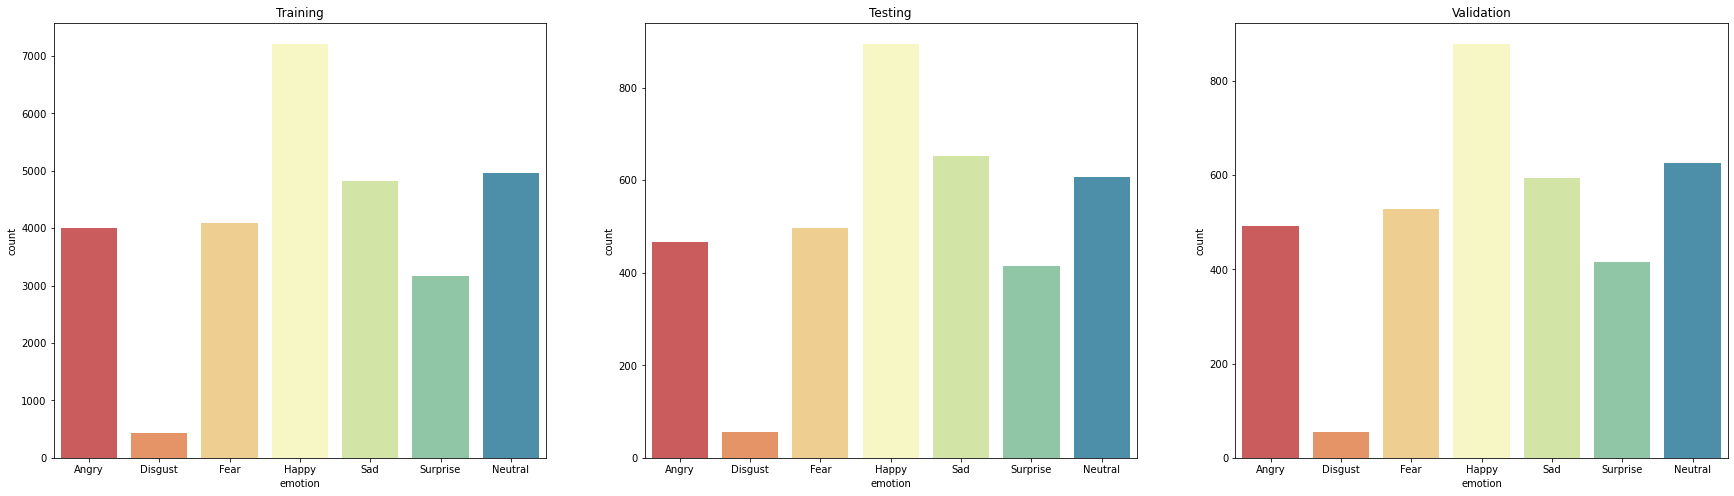

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(30,8))

sns.countplot(data = df[df['Usage']=='Training'], x='emotion', ax=ax1, palette='Spectral').set_title('Training')
ax1.set_xticklabels(emotions.values())

sns.countplot(data = df[df['Usage']=='PublicTest'], x='emotion', ax=ax2, palette='Spectral').set_title('Testing')
ax2.set_xticklabels(emotions.values())

sns.countplot(data = df[df['Usage']=='PrivateTest'], x='emotion', ax=ax3, palette='Spectral').set_title('Validation')
ax3.set_xticklabels(emotions.values())

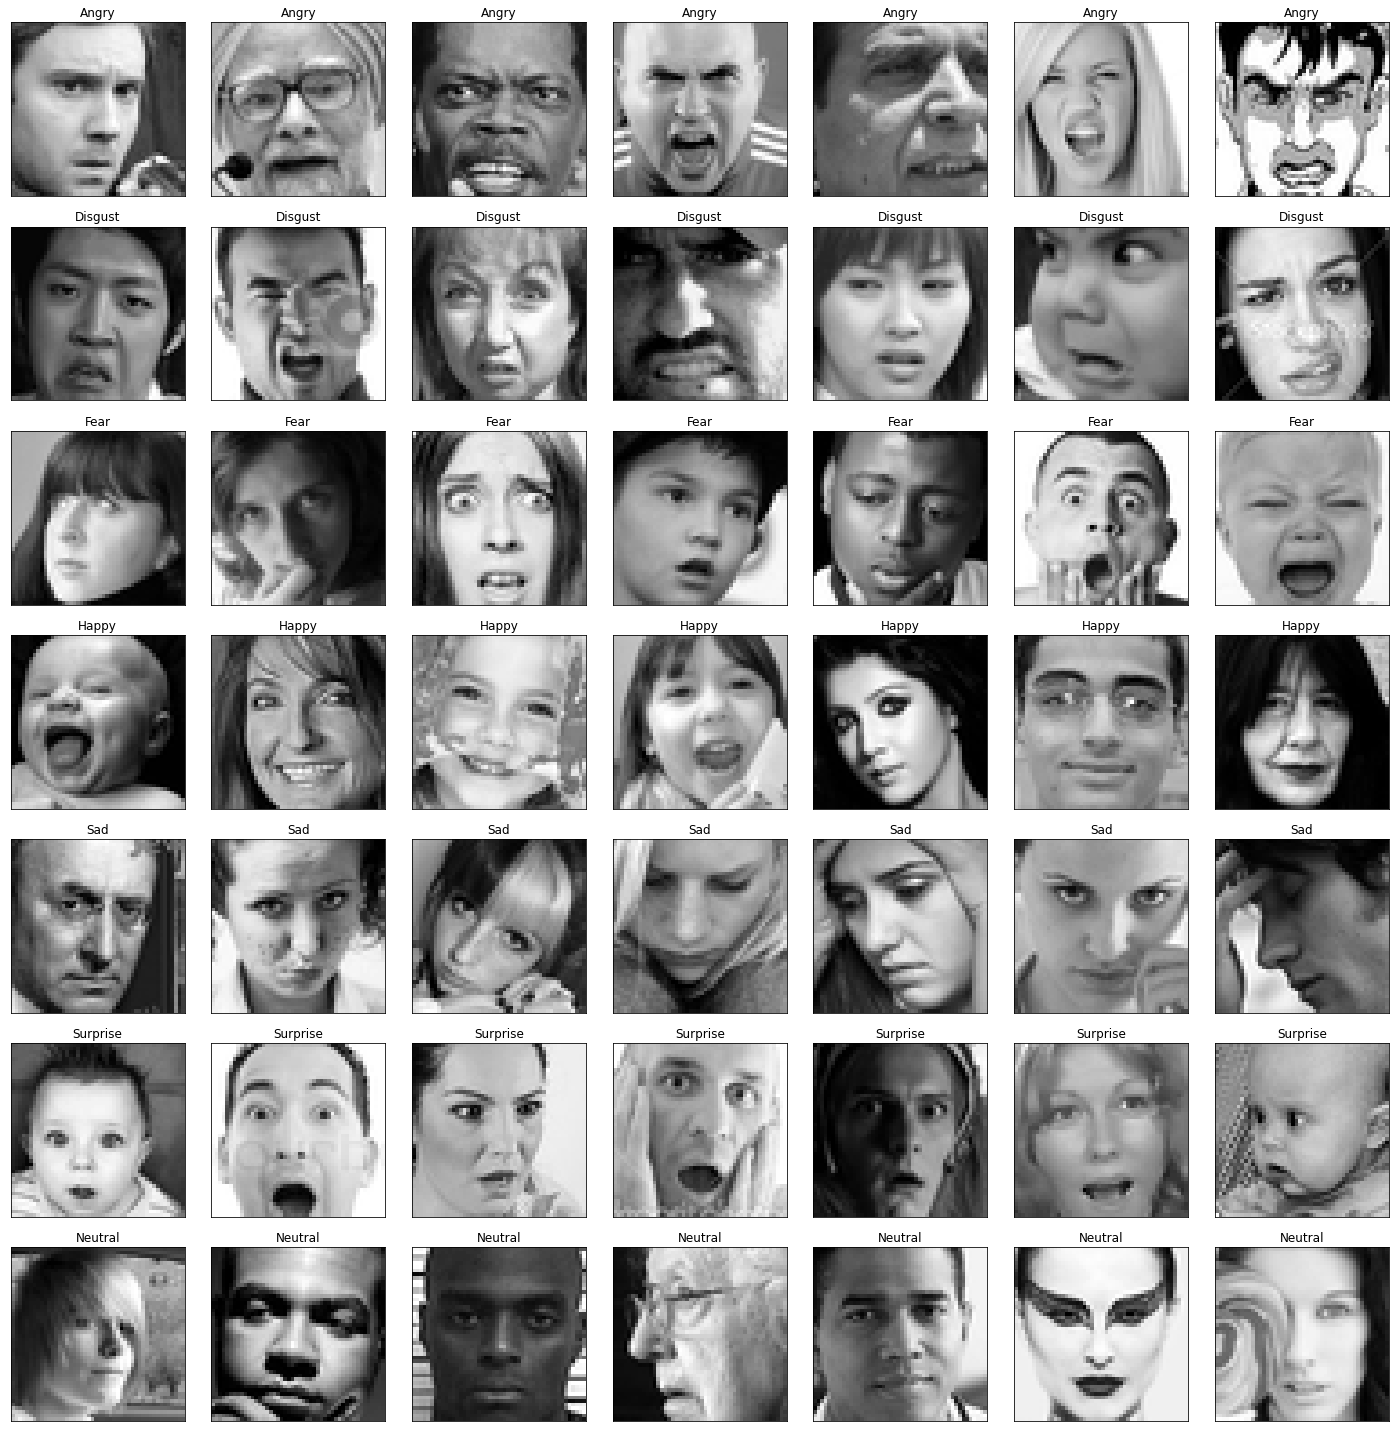

In [10]:
fig = plt.figure(1, (20, 20))

k = 0
for label in sorted(df['emotion'].unique()):
    for j in range(7):
        px = df[df['emotion']==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions[label])
        plt.tight_layout()

In [25]:
train_data = df[df['Usage']=='Training']
train_data.drop(columns='Usage', inplace=True)
train_data.head()

C:\Users\Lenovo\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...

In [26]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) 
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

In [27]:
X_train, y_train = prepare_data(train_data)
print(X_train.shape, y_train.shape)

(28709, 48, 48, 1) (28709,)


In [28]:
test_data = df[df['Usage']!='Training']
test_data.drop(columns='Usage', inplace=True)
test_data.head()

C:\Users\Lenovo\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


emotion                                             pixels
28709        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...
28710        1  156 184 198 202 204 207 210 212 213 214 215 21...
28711        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...
28712        6  205 203 236 157 83 158 120 116 94 86 155 180 2...
28713        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...

In [29]:
X_test, y_test = prepare_data(test_data)
print(X_test.shape, y_test.shape)

(7178, 48, 48, 1) (7178,)


In [30]:
from keras.models import load_model

loaded_our_model = load_model('model.h5')
print('Our model loaded')

Our model loaded


In [31]:
#make prediction
yhat_test = np.argmax(loaded_our_model.predict(X_test), axis=1)
yhat_test

225/225 [==============================] - 106s 453ms/step


array([0, 1, 4, ..., 0, 3, 2], dtype=int64)

In [ ]:
y_test = np.argmax(y_test, axis=1)
y_test

In [33]:
#get classification report
print(classification_report(y_test, yhat_test, target_names=emotions.values()))

              precision    recall  f1-score   support

       Angry       0.90      0.93      0.91       958
     Disgust       0.94      0.92      0.93       111
        Fear       0.88      0.93      0.90      1024
       Happy       0.97      0.97      0.97      1774
         Sad       0.92      0.92      0.92      1247
    Surprise       0.93      0.96      0.95       831
     Neutral       0.96      0.88      0.92      1233

    accuracy                           0.93      7178
   macro avg       0.93      0.93      0.93      7178
weighted avg       0.93      0.93      0.93      7178



[[ 892    2   29    4   18    5    8]
 [   4  102    2    1    2    0    0]
 [  20    1  949    3   21   21    9]
 [  12    2   17 1714    8   10   11]
 [  27    1   30   22 1145    6   16]
 [   7    0   11    8    1  801    3]
 [  30    0   38   24   44   14 1083]]


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17028/1756051866.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


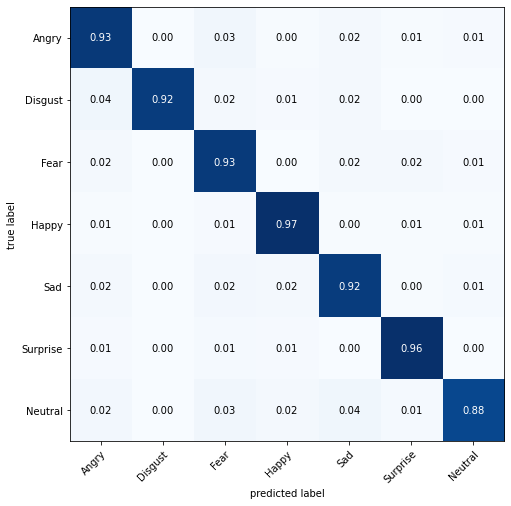

In [34]:
from mlxtend.plotting import plot_confusion_matrix

#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

1/1 [==============================] - 0s 58ms/step


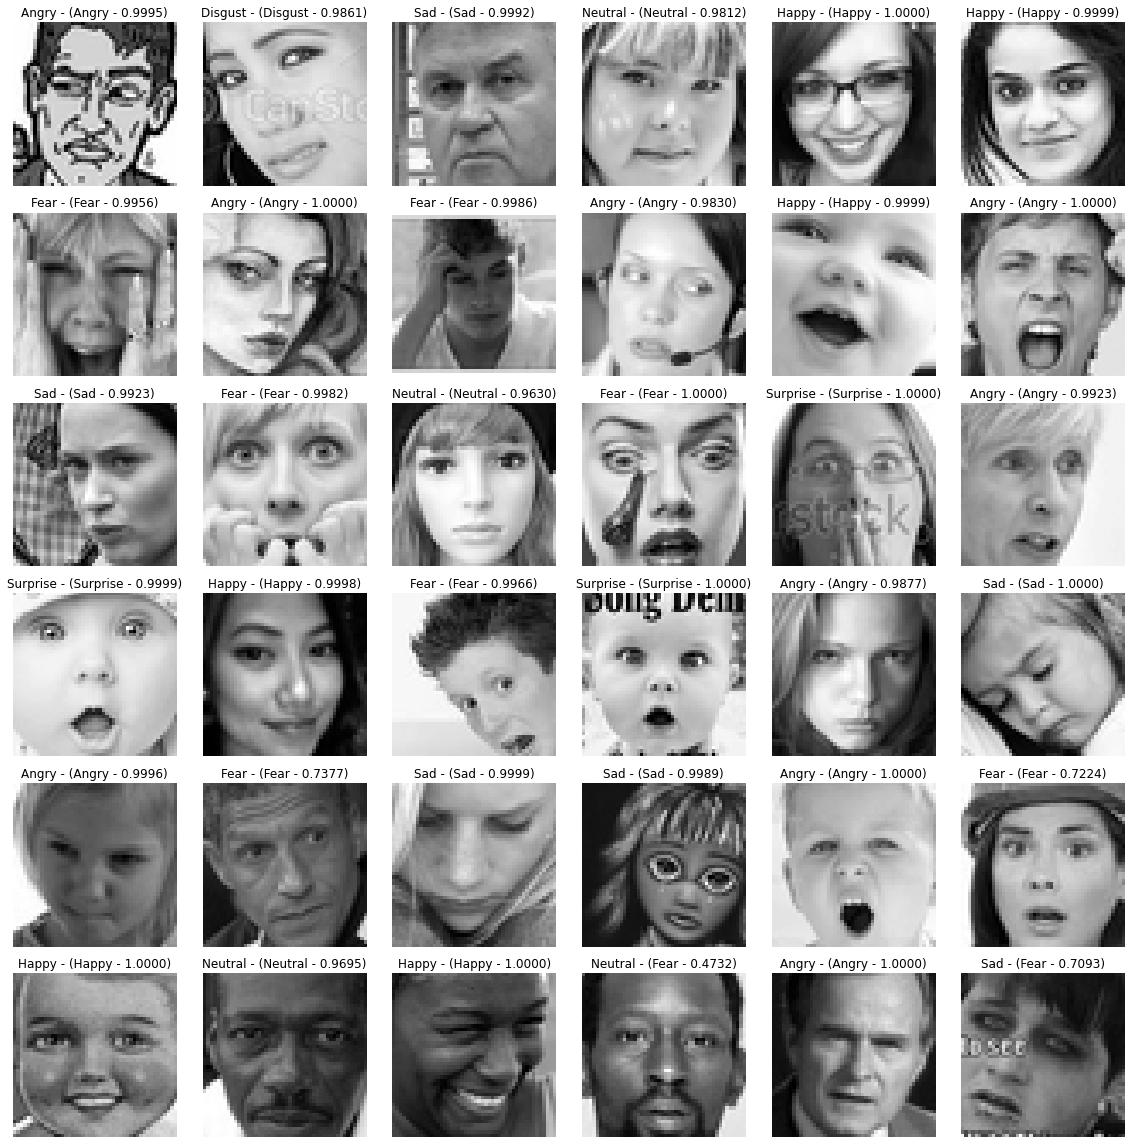

In [36]:
plt.figure(figsize=[16,16])

for i in range(36):
    img = X_test[i,:,:,0]
    p_dist = loaded_our_model.predict(img.reshape(1, 48, 48, 1))
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    plt.subplot(6, 6, i+1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'{emotions[y_test[i]]} - ({emotions[k]} - {p:.4f})')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [37]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,self.model.output]
       )
           
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

1/1 [==============================] - 0s 35ms/step


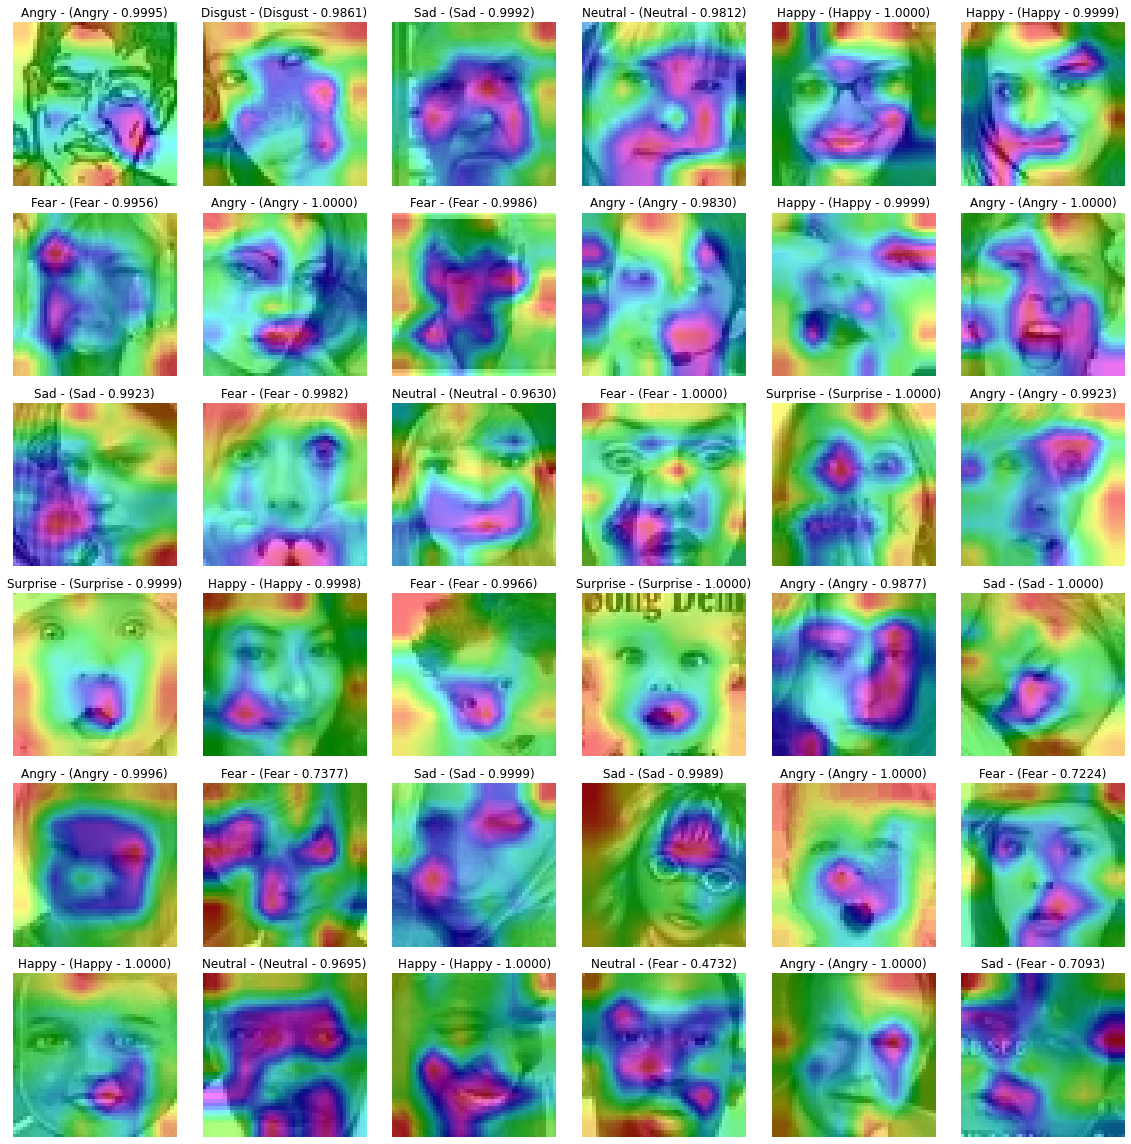

In [40]:
plt.figure(figsize=[16,16])
for i in range(36):
    img = X_test[i,:,:,0]
    p_dist = loaded_our_model.predict(img.reshape(1, 48, 48, 1))
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    cam = GradCAM(loaded_our_model, k)
    heatmap = cam.compute_heatmap(img.reshape(1, 48, 48, 1))

    plt.subplot(6, 6, i+1)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='hsv')
    plt.title(f'{emotions[y_test[i]]} - ({emotions[k]} - {p:.4f})')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

225/225 [==============================] - 108s 482ms/step


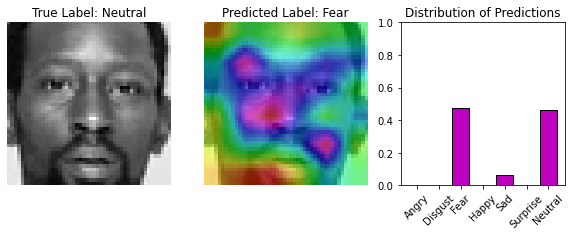

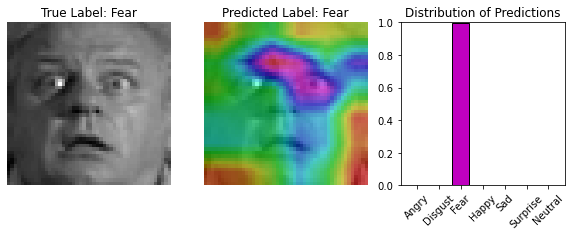

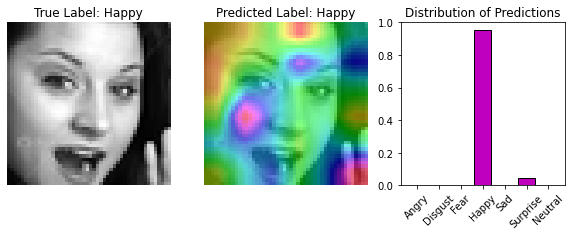

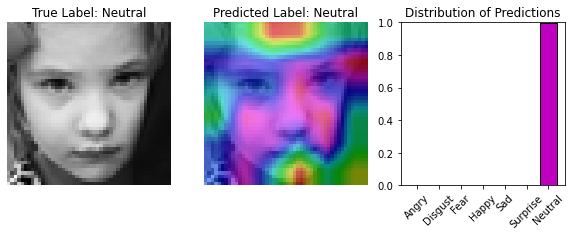

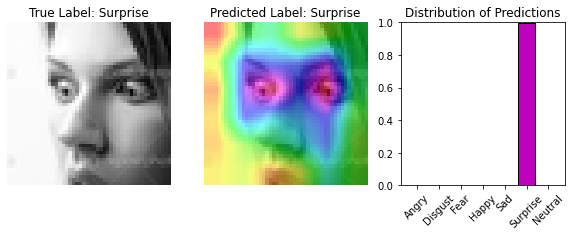

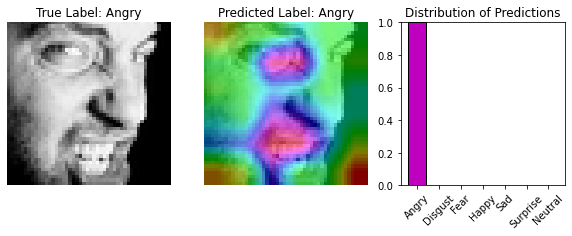

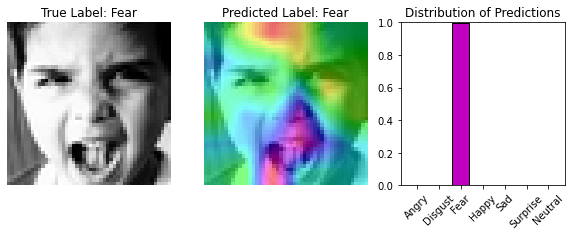

In [43]:
test_prob = loaded_our_model.predict(X_test)
test_pred = np.argmax(test_prob, axis=1)

sel_imgs = [33, 1000, 88, 777, 108, 111, 7000]

for n in sel_imgs:
    img = X_test[n,:,:,0]
    
    plt.figure(figsize=[10,3])
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'True Label: {emotions[y_test[n]]}')
    plt.axis('off')
    
    cam = GradCAM(loaded_our_model, test_pred[n])
    heatmap = cam.compute_heatmap(img.reshape(1,48,48,1))
    
    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='hsv')
    plt.title(f'Predicted Label: {emotions[test_pred[n]]}')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.bar(emotions.values(), test_prob[n, :], color='m', edgecolor='k')
    plt.xticks(rotation=45)
    plt.ylim([0,1])
    plt.title('Distribution of Predictions')
    plt.show()